<a href="https://colab.research.google.com/github/Biruk-gebru/Diffusion-Model/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Install required packages
!pip install torch torchvision matplotlib tqdm numpy

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import math
import random
from typing import Optional, Tuple

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Using device: {device}")

 Using device: cuda


In [10]:
class NoiseScheduler:
    """Handles different noise scheduling strategies for diffusion models."""

    def __init__(self, timesteps: int = 1000, scheduler_type: str = "linear"):
        self.timesteps = timesteps
        self.scheduler_type = scheduler_type
        self.betas = torch.zeros(timesteps)
        self.alphas = torch.zeros(timesteps)
        self.alpha_hats = torch.zeros(timesteps)
        self._setup_schedule()

    def _setup_schedule(self):
        """Initialize the noise schedule based on the chosen type."""
        if self.scheduler_type == "linear":
            self.betas = self._linear_beta_schedule()
        elif self.scheduler_type == "cosine":
            self.betas = self._cosine_beta_schedule()
        elif self.scheduler_type == "exponential":
            self.betas = self._exponential_beta_schedule()
        else:
            raise ValueError(f"Unknown scheduler type: {self.scheduler_type}")

        self.alphas = 1.0 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

    def _linear_beta_schedule(self, beta_start: float = 1e-4, beta_end: float = 0.02):
        """Linear noise schedule."""
        return torch.linspace(beta_start, beta_end, self.timesteps)

    def _cosine_beta_schedule(self, s: float = 0.008):
        """Cosine noise schedule for better quality."""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

    def _exponential_beta_schedule(self, base: float = 1.02, beta_start: float = 1e-4):
        """Exponential noise schedule."""
        return beta_start * (base ** torch.arange(self.timesteps))

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """Add noise to images at timestep t."""
        if noise is None:
            noise = torch.randn_like(x0)

        # Move scheduler tensors to the same device as input
        device = x0.device
        alpha_hats = self.alpha_hats.to(device)

        sqrt_alpha_hat = alpha_hats[t].view(-1, 1, 1, 1).sqrt()
        sqrt_one_minus_alpha_hat = (1 - alpha_hats[t]).view(-1, 1, 1, 1).sqrt()

        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

In [3]:
class SinusoidalTimeEmbedding(nn.Module):
    """Sinusoidal time embedding for diffusion models."""

    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim

        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.act = nn.SiLU()
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        device = t.device
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)

        emb = self.linear1(emb)
        emb = self.act(emb)
        emb = self.linear2(emb)
        return emb

class LabelEmbedding(nn.Module):
    """Label embedding for conditional generation."""

    def __init__(self, num_classes: int = 10, embed_dim: int = 128):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        emb = self.embed(labels)
        return self.projection(emb)

In [15]:
class SelfAttentionBlock(nn.Module):
    """Self-attention block for global reasoning."""

    def __init__(self, channels: int):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 8, batch_first=True)
        self.norm = nn.GroupNorm(8, channels)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.tensor(0.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x_norm = self.norm(x)

        x_flat = x_norm.view(B, C, H * W).permute(0, 2, 1)
        attn_out, _ = self.mha(x_flat, x_flat, x_flat)
        attn_out = attn_out.permute(0, 2, 1).view(B, C, H, W)

        out = self.proj(attn_out)
        return self.gamma * out + x

class ResBlock(nn.Module):
    """Residual block with time and label conditioning."""

    def __init__(self, in_channels: int, out_channels: int, time_embed_dim: int, label_embed_dim: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Main conv layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        # Normalization
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)

        # Time conditioning
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, out_channels)
        )

        # Label conditioning
        self.label_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(label_embed_dim, out_channels)
        )

        # Shortcut connection - handle channel mismatch
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x: torch.Tensor, time_embed: torch.Tensor, label_embed: torch.Tensor) -> torch.Tensor:
        h = x

        # First conv
        h = self.conv1(h)
        h = self.norm1(h)

        # Add time and label conditioning
        time_cond = self.time_mlp(time_embed)[:, :, None, None]
        label_cond = self.label_mlp(label_embed)[:, :, None, None]
        h = h + time_cond + label_cond

        h = F.silu(h)

        # Second conv
        h = self.conv2(h)
        h = self.norm2(h)

        # Add time and label conditioning again
        h = h + time_cond + label_cond

        h = F.silu(h)

        # Add shortcut connection
        return h + self.shortcut(x)

class DownBlock(nn.Module):
    """Downsampling block with attention."""

    def __init__(self, in_channels: int, out_channels: int, time_embed_dim: int, label_embed_dim: int, use_attention: bool = True):
        super().__init__()
        self.res1 = ResBlock(in_channels, out_channels, time_embed_dim, label_embed_dim)
        self.res2 = ResBlock(out_channels, out_channels, time_embed_dim, label_embed_dim)
        self.attention = SelfAttentionBlock(out_channels) if use_attention else nn.Identity()
        self.downsample = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, time_embed: torch.Tensor, label_embed: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.res1(x, time_embed, label_embed)
        h = self.res2(h, time_embed, label_embed)
        h = self.attention(h)
        skip = h
        h = self.downsample(h)
        return h, skip

class UpBlock(nn.Module):
    """Upsampling block with attention."""

    def __init__(self, in_channels: int, out_channels: int, time_embed_dim: int, label_embed_dim: int, use_attention: bool = True):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        # Fix: Use in_channels for the concatenated input (upsampled + skip)
        self.res1 = ResBlock(in_channels + in_channels, out_channels, time_embed_dim, label_embed_dim)
        self.res2 = ResBlock(out_channels, out_channels, time_embed_dim, label_embed_dim)
        self.attention = SelfAttentionBlock(out_channels) if use_attention else nn.Identity()

    def forward(self, x: torch.Tensor, skip: torch.Tensor, time_embed: torch.Tensor, label_embed: torch.Tensor) -> torch.Tensor:
        h = self.upsample(x)

        # Ensure skip connection has the same spatial size
        if h.shape[2:] != skip.shape[2:]:
            h = F.interpolate(h, size=skip.shape[2:], mode='bilinear', align_corners=False)

        # Ensure skip connection has the same number of channels as upsampled tensor
        if h.shape[1] != skip.shape[1]:
            # Use 1x1 conv to match channels
            skip = nn.Conv2d(skip.shape[1], h.shape[1], 1).to(skip.device)(skip)

        h = torch.cat([h, skip], dim=1)
        h = self.res1(h, time_embed, label_embed)
        h = self.res2(h, time_embed, label_embed)
        h = self.attention(h)
        return h

In [17]:
class ConditionalUNet(nn.Module):
    """Proper U-Net architecture for diffusion models."""

    def __init__(self,
                 in_channels: int = 1,
                 model_channels: int = 128,
                 out_channels: int = 1,
                 num_res_blocks: int = 2,
                 time_embed_dim: int = 128,
                 label_embed_dim: int = 128):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.time_embed_dim = time_embed_dim
        self.label_embed_dim = label_embed_dim

        # Time embedding
        self.time_embed = SinusoidalTimeEmbedding(time_embed_dim)

        # Label embedding
        self.label_embed = LabelEmbedding(embed_dim=label_embed_dim)

        # Initial convolution
        self.input_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)

        # Downsampling path - simpler structure
        self.down1 = DownBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)
        self.down2 = DownBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)
        self.down3 = DownBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)

        # Middle
        self.middle = nn.ModuleList([
            ResBlock(model_channels, model_channels, time_embed_dim, label_embed_dim),
            SelfAttentionBlock(model_channels),
            ResBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)
        ])

        # Upsampling path
        self.up3 = UpBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)
        self.up2 = UpBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)
        self.up1 = UpBlock(model_channels, model_channels, time_embed_dim, label_embed_dim)

        # Output
        self.output = nn.Sequential(
            nn.GroupNorm(8, model_channels),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, 3, padding=1)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        # Time and label embeddings
        time_embed = self.time_embed(t)
        label_embed = self.label_embed(labels)

        # Initial conv
        h = self.input_conv(x)

        # Downsampling with skip connections
        h1, skip1 = self.down1(h, time_embed, label_embed)
        h2, skip2 = self.down2(h1, time_embed, label_embed)
        h3, skip3 = self.down3(h2, time_embed, label_embed)

        # Middle
        for block in self.middle:
            if isinstance(block, SelfAttentionBlock):
                h3 = block(h3)
            else:
                h3 = block(h3, time_embed, label_embed)

        # Upsampling with skip connections
        h = self.up3(h3, skip3, time_embed, label_embed)
        h = self.up2(h, skip2, time_embed, label_embed)
        h = self.up1(h, skip1, time_embed, label_embed)

        # Output
        return self.output(h)

In [11]:
class DiffusionSampler:
    """Handles the reverse diffusion sampling process."""

    def __init__(self, scheduler: NoiseScheduler):
        self.scheduler = scheduler

    @torch.no_grad()
    def sample(self,
               model: nn.Module,
               labels: torch.Tensor,
               batch_size: int = 1,
               image_size: int = 28,
               channels: int = 1,
               steps: Optional[int] = None) -> torch.Tensor:
        """Sample images using the trained diffusion model."""
        model.eval()

        if steps is None:
            steps = self.scheduler.timesteps

        # Start from pure noise
        device = next(model.parameters()).device
        x = torch.randn(batch_size, channels, image_size, image_size, device=device)

        # Move scheduler tensors to device
        alphas = self.scheduler.alphas.to(device)
        alpha_hats = self.scheduler.alpha_hats.to(device)
        betas = self.scheduler.betas.to(device)

        # Reverse diffusion process
        for t in reversed(range(steps)):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)

            # Predict noise
            predicted_noise = model(x, t_tensor, labels)

            # Get current alpha and beta values
            alpha = alphas[t]
            alpha_hat = alpha_hats[t]
            beta = betas[t]

            # Denoising step
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            # DDPM sampling equation
            x = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_hat).sqrt()) * predicted_noise) + beta.sqrt() * noise

        return x

In [7]:
def visualize_samples(samples: torch.Tensor, labels: torch.Tensor, num_samples: int = 8):
    """Visualize generated samples."""
    samples = samples[:num_samples].cpu()
    labels = labels[:num_samples].cpu()

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        axes[i].imshow(samples[i][0], cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def save_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer,
                   scheduler, epoch: int, loss: float, path: str):
    """Save model checkpoint."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, path)

def generate_from_prompt(prompt: str, model_path: str = "best_diffusion_model.pth", num_samples: int = 1):
    """Generate images from a text prompt."""
    # Simple prompt parsing for MNIST digits
    digit_mapping = {
        'zero': 0, '0': 0, 'digit 0': 0,
        'one': 1, '1': 1, 'digit 1': 1,
        'two': 2, '2': 2, 'digit 2': 2,
        'three': 3, '3': 3, 'digit 3': 3,
        'four': 4, '4': 4, 'digit 4': 4,
        'five': 5, '5': 5, 'digit 5': 5,
        'six': 6, '6': 6, 'digit 6': 6,
        'seven': 7, '7': 7, 'digit 7': 7,
        'eight': 8, '8': 8, 'digit 8': 8,
        'nine': 9, '9': 9, 'digit 9': 9,
    }

    # Parse prompt
    prompt_lower = prompt.lower().strip()
    if prompt_lower in digit_mapping:
        label = digit_mapping[prompt_lower]
    else:
        import random
        label = random.randint(0, 9)
        print(f"Prompt '{prompt}' not recognized. Generating random digit {label}")

    # Load model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    scheduler = NoiseScheduler(timesteps=1000, scheduler_type="cosine")
    model = ConditionalUNet(
        in_channels=1,
        model_channels=128,
        out_channels=1,
        num_res_blocks=2,
        time_embed_dim=128,
        label_embed_dim=128
    )

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # Generate
    sampler = DiffusionSampler(scheduler)
    labels = torch.full((num_samples,), label, device=device)
    samples = sampler.sample(model, labels, batch_size=num_samples, steps=50)

    return samples, label

In [ ]:
def main():
    """Main training function optimized for Colab."""
    # Device setup with GPU detection
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    if device == "cuda":
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Data setup with proper Colab paths
    print("Loading MNIST dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Use Colab-friendly data path
    data_path = "./data" if not torch.cuda.is_available() else "/content/data"
    train_data = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

    print(f"Dataset loaded: {len(train_data)} training samples")

    # Model setup
    print("Initializing model...")
    scheduler = NoiseScheduler(timesteps=1000, scheduler_type="cosine")
    model = ConditionalUNet(
        in_channels=1,
        model_channels=128,
        out_channels=1,
        num_res_blocks=2,
        time_embed_dim=128,
        label_embed_dim=128
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

    # Training setup
    trainer = DiffusionTrainer(
        model=model,
        scheduler=scheduler,
        device=device,
        learning_rate=1e-4
    )

    # Training loop
    num_epochs = 20
    best_loss = float('inf')

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        avg_loss = trainer.train_epoch(train_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_checkpoint(
                model, trainer.optimizer, trainer.lr_scheduler,
                epoch, avg_loss, "best_diffusion_model.pth"
            )
            print(f" New best model saved! Loss: {best_loss:.6f}")

        # Generate samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("Generating sample images...")
            sampler = DiffusionSampler(scheduler)
            test_labels = torch.arange(10, device=device)
            samples = sampler.sample(model, test_labels, batch_size=10, steps=50)
            visualize_samples(samples, test_labels)



# Start training
if __name__ == "__main__":
    main()

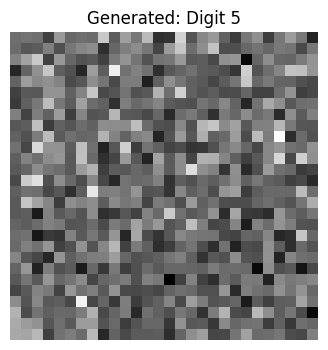

In [21]:
# Generate images from prompts
samples, label = generate_from_prompt("digit 5")

# Display
plt.figure(figsize=(4, 4))
plt.imshow(samples[0][0].cpu(), cmap='gray')
plt.title(f'Generated: Digit {label}')
plt.axis('off')
plt.show()